## Write up report using Covid Positive X-Ray image data

### Name:Rolando Chapiro Uziel 
### Uni: rc3434

Link to github: 

https://github.com/rochapiro/Projects-in-Machine-Learning/blob/main/COVID%20Image%20Detection/COVID_image_detection.ipynb

#### 1. Use Google Drive link to view a folder I shared with @columbia.edu google drive users
https://drive.google.com/drive/folders/18O-BnGOIw9ZiUwy17Uk_361xyfTF-qAN?usp=sharing
#### 2. Right click folder and click "Add shortcut to Drive"
This will be sure the zipfile in this folder is accessible in your personal drive folder


In [ ]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import data and unzip files to folder
!unzip -o /content/drive/MyDrive/COVID-19_Radiography_Dataset.zip

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [ ]:
fnames[1]

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        # import image, make sure it's RGB and resize to height and width you want.
        img = Image.open(img_path).convert("RGB").resize((192,192)) 
        # min max transformation
        img = (np.float32(img)-1.)/(255-1.) 
        # Create final shape as array with correct dimensions for Keras
        img=img.reshape((192,192,3)) 
        
        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

4032

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [ ]:
len(fnames[2])

1344

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
4027,0,0,1
4028,0,0,1
4029,0,0,1
4030,0,0,1


## Visualization of images that show lungs with, COVID, With no COVID and with Pneumonia

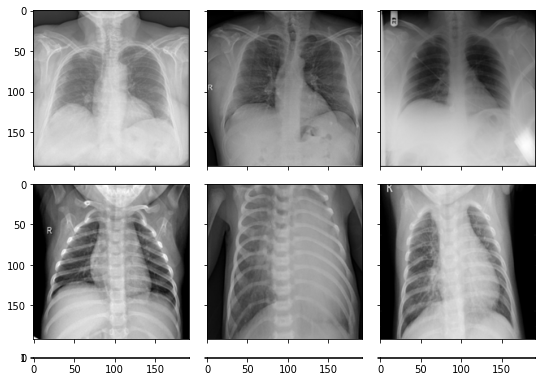

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

# Lungs with COVID
im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])

# Lungs with no COVID 
im3 =preprocessor(fnames[1][0])
im4 =preprocessor(fnames[1][1])

# Lungs with Pneumonia 
im5= preprocessor(fnames[2][0])
im6= preprocessor(fnames[2][1])


fig = plt.figure(figsize=(9., 9.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

## Why Build a predictive Model using these images as data? 

The data set contains x-ray images of different patients lungs. Amongst these images there are somme that contain COVID, Pneumonia and lungs with no visible medical issues. Using the data briefly described above, to produce a model that has the ability to accuratley, detect Lungs with and without COVID can be of substantial imporance as during the peak of the pandemic the need for X-ray analysis by medical professionals surpassed the availability of doctors whi the necesary knowledge to look over the X-rays. Building a model with a high accuracy rate in predicting COVID incidence based only off image data would deliver results and potetntial treatment in a much more effective manner to the appropriate pattients. There is a large space for a value added model with the ability to performe such task; specially in periods of high demand for medical professionals that gover over X-rays one by one. 

In [ ]:
#Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape
#print(X_train.shape, y_train.shape)

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

## Building 3 different models to approach the COVID image detection problem

### First apporach: A CONV2D model with Maxpooling

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, epochs = 5, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/5
69/69 [==============================] - 22s 156ms/step - loss: 0.9321 - accuracy: 0.4991 - val_loss: 0.6798 - val_accuracy: 0.7158
Epoch 2/5
69/69 [==============================] - 8s 123ms/step - loss: 0.5888 - accuracy: 0.7318 - val_loss: 0.5426 - val_accuracy: 0.7650
Epoch 3/5
69/69 [==============================] - 8s 121ms/step - loss: 0.4902 - accuracy: 0.7888 - val_loss: 0.5588 - val_accuracy: 0.7923
Epoch 4/5
69/69 [==============================] - 8s 121ms/step - loss: 0.4382 - accuracy: 0.8234 - val_loss: 0.4657 - val_accuracy: 0.8397
Epoch 5/5
69/69 [==============================] - 8s 122ms/step - loss: 0.3415 - accuracy: 0.8677 - val_loss: 0.4360 - val_accuracy: 0.8379


In [ ]:
# save the model
model.save("model", save_format="h5")

In [ ]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

In [ ]:
# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       16512     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 128)      0         
 2D)                                                    

In [ ]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

41/41 [==============================] - 2s 56ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 394

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


In [ ]:
data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

## Second apporach:A CONV2D model with Maxpooling and  Batch normalization

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)


# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)    

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

X_train.shape, y_train.shape

((2741, 192, 192, 3), (2741, 3))

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, epochs = 5, verbose=1,validation_split=.2)

Epoch 1/5
69/69 [==============================] - 24s 177ms/step - loss: 0.9990 - accuracy: 0.7961 - val_loss: 1.3913 - val_accuracy: 0.3206
Epoch 2/5
69/69 [==============================] - 9s 136ms/step - loss: 0.2731 - accuracy: 0.8992 - val_loss: 1.1592 - val_accuracy: 0.4699
Epoch 3/5
69/69 [==============================] - 9s 134ms/step - loss: 0.2483 - accuracy: 0.9097 - val_loss: 1.6692 - val_accuracy: 0.3279
Epoch 4/5
69/69 [==============================] - 9s 136ms/step - loss: 0.1966 - accuracy: 0.9279 - val_loss: 1.2272 - val_accuracy: 0.4791
Epoch 5/5
69/69 [==============================] - 9s 134ms/step - loss: 0.1801 - accuracy: 0.9443 - val_loss: 2.3859 - val_accuracy: 0.3734


In [ ]:
# save the model
model.save("model2", save_format="h5")

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('model2',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 batch_normalization (BatchN  (None, 192, 192, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 128)       1

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model

#-- Generate predicted y values
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

### Third approach: Transfer learning

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)    

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

X_train.shape, y_train.shape

((2741, 192, 192, 3), (2741, 3))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# load the pre-trained VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# set the layers of the base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# create a new model on top of the imported model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model on the training data
model.fit(X_train, y_train, epochs = 5, verbose=1,validation_split=.2)

Epoch 1/5
69/69 [==============================] - 17s 177ms/step - loss: 0.3649 - accuracy: 0.8755 - val_loss: 0.4072 - val_accuracy: 0.8488
Epoch 2/5
69/69 [==============================] - 10s 138ms/step - loss: 0.1459 - accuracy: 0.9443 - val_loss: 0.3448 - val_accuracy: 0.8725
Epoch 3/5
69/69 [==============================] - 10s 138ms/step - loss: 0.0828 - accuracy: 0.9731 - val_loss: 0.1804 - val_accuracy: 0.9326
Epoch 4/5
69/69 [==============================] - 10s 139ms/step - loss: 0.0659 - accuracy: 0.9763 - val_loss: 0.2179 - val_accuracy: 0.9235
Epoch 5/5
69/69 [==============================] - 10s 140ms/step - loss: 0.0445 - accuracy: 0.9849 - val_loss: 0.2719 - val_accuracy: 0.9253


In [ ]:
# save the model
model.save("model3", save_format="h5")

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('model3',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                        

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model3.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model

#-- Generate predicted y values 
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model3.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

The previos 3 model were submitted to Covid X-ray Diagnostic AI Model Share competition

#### Model discussion: 
After seeing the change between the 3 models presented above we can clearly see the effect that Batch normalization has on the model as its performace increased as a result of its inclusion in the model when we compare the first two. The model improved substatially when Transfer learning was used as it was buitl on top of the VGG16 architecture, both filter size and number of filter proved to be an importnat element in model performance 

### Post Discussion model 1: Tranfer learning using ResNet50



In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)    

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

X_train.shape, y_train.shape

((2741, 192, 192, 3), (2741, 3))

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model on the training data
model.fit(X_train, y_train, epochs = 5, verbose=1,validation_split=.2)


Epoch 1/5
69/69 [==============================] - 15s 129ms/step - loss: 1.8879 - accuracy: 0.3257 - val_loss: 1.0986 - val_accuracy: 0.3406
Epoch 2/5
69/69 [==============================] - 6s 91ms/step - loss: 1.1015 - accuracy: 0.3175 - val_loss: 1.0986 - val_accuracy: 0.3388
Epoch 3/5
69/69 [==============================] - 7s 95ms/step - loss: 1.0987 - accuracy: 0.3225 - val_loss: 1.0987 - val_accuracy: 0.3188
Epoch 4/5
69/69 [==============================] - 6s 91ms/step - loss: 1.0987 - accuracy: 0.3280 - val_loss: 1.0987 - val_accuracy: 0.3188
Epoch 5/5
69/69 [==============================] - 6s 90ms/step - loss: 1.0987 - accuracy: 0.3367 - val_loss: 1.0987 - val_accuracy: 0.3188


In [ ]:
# save the model
model.save("model4", save_format="h5")

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('model4',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 96, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model

#-- Generate predicted y values 
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model4.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

### Post Discussion model 2: Tranfer learning using VGG16





In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)    

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

X_train.shape, y_train.shape

((2741, 192, 192, 3), (2741, 3))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# load the pre-trained VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

# set the layers of the base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# create a new model on top of the imported model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model on the training data
model.fit(X_train, y_train, epochs = 5, verbose=1,validation_split=.2)

Epoch 1/5
69/69 [==============================] - 23s 183ms/step - loss: 0.4886 - accuracy: 0.8353 - val_loss: 1.2594 - val_accuracy: 0.6211
Epoch 2/5
69/69 [==============================] - 9s 137ms/step - loss: 0.2124 - accuracy: 0.9252 - val_loss: 0.3441 - val_accuracy: 0.8925
Epoch 3/5
69/69 [==============================] - 10s 141ms/step - loss: 0.2003 - accuracy: 0.9320 - val_loss: 0.1463 - val_accuracy: 0.9417
Epoch 4/5
69/69 [==============================] - 9s 138ms/step - loss: 0.1239 - accuracy: 0.9544 - val_loss: 0.2097 - val_accuracy: 0.9344
Epoch 5/5
69/69 [==============================] - 10s 151ms/step - loss: 0.0976 - accuracy: 0.9662 - val_loss: 0.2479 - val_accuracy: 0.9308


In [ ]:
# save the model
model.save("model5", save_format="h5")

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('model5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                        

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model5.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model

#-- Generate predicted y values 
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model5.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

41/41 [==============================] - 6s 140ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 415

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Post Discussion model 3: Tranfer learning using InceptionV3 with BatchNormalization

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)    

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

X_train.shape, y_train.shape

((2741, 192, 192, 3), (2741, 3))

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(192, 192, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fitting the model on the training data
model.fit(X_train, y_train, epochs = 5, verbose=1,validation_split=.2)



Epoch 1/5
69/69 [==============================] - 16s 136ms/step - loss: 0.5656 - accuracy: 0.7933 - val_loss: 0.3857 - val_accuracy: 0.8306
Epoch 2/5
69/69 [==============================] - 5s 74ms/step - loss: 0.3227 - accuracy: 0.8654 - val_loss: 0.4315 - val_accuracy: 0.8452
Epoch 3/5
69/69 [==============================] - 5s 69ms/step - loss: 0.3164 - accuracy: 0.8636 - val_loss: 0.4962 - val_accuracy: 0.8306
Epoch 4/5
69/69 [==============================] - 5s 74ms/step - loss: 0.2899 - accuracy: 0.8791 - val_loss: 0.3747 - val_accuracy: 0.8616
Epoch 5/5
69/69 [==============================] - 5s 74ms/step - loss: 0.2395 - accuracy: 0.8983 - val_loss: 0.5884 - val_accuracy: 0.8015


In [ ]:
# save the model
model.save("model6", save_format="h5")

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('model6',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_564 (Conv2D)            (None, 95, 95, 32)   864         ['input_7[0][0]']                
                                                                                                  
 batch_normalization_566 (Batch  (None, 95, 95, 32)  96          ['conv2d_564[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [ ]:
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model6.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model

#-- Generate predicted y values 
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model6.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip")

41/41 [==============================] - 5s 73ms/step


/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:302: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  leaderboard = leaderboard.append(metadata, ignore_index=True, sort=False)
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:304: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  leaderboard['username']=leaderboard.pop("username")
/usr/local/lib/python3.9/dist-packages/aimodelshare/model.py:305: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 419

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Discussion about successful models: 
It seems that the best approach to takle this problem and generate the highest accuracy models was to use Transfer learnig; in particular building on top VGG16. It seemms that filter size as well as the depth of these had a significant impact in the models performance. We compared different model architectures to takle this problem and it seems that VGG16 performed better than ResNet and InceptionV3. Building on top of these existing and proven architectures seems to be the most effective approach as these models performed better than those where the archirecture was not a well established one but rather a guessing game. Transfer learning is a powerfull tool that helped increase the models performace for the detection of COVID 19 in X-ray image data. 